In [2]:
myPath <- .libPaths()
myPath <- c(myPath,"/home/yanhu/utils/R/R_packages")
.libPaths(myPath)

library(GenomicRanges)
library(SummarizedExperiment)
library(ggplot2)

In [3]:
# Fast running window sum. This runs a window with radius = r across the input vector x and calculates running sum
# For any position i, this sums x[(i - r + 1) : (i + r)]
conv <- function(x, # Input vector x
                 r # Window radius
                 ){
  smoothKernel <- rep(1, 2 * r)
  xConv <- cladoRcpp::rcpp_convolve(x, smoothKernel)
  xConv[(r + 1):(length(x) + r)]
}

In [43]:
frags_dir <- "/home/yanhu/data/DddA/HJR288/single_sgRNA_validation/fragments/"
frag_files <- list.files(frags_dir)
samples <- stringr::str_split_fixed(frag_files, "\\.", 3)[,1]

# Divide the locus into bins
locus <- GRanges("chr11:5245964-5257447")
locusBins <- tile(locus, width = 1)[[1]]

# Calculate coverage tracks within the target locus for each selecte sample
tracks <- pbmcapply::pbmcmapply(
  function(sample){
    
    # Load fragment coordinates of the current sample
    frags <- data.table::fread(
      paste0(frags_dir, sample, ".frags.gz"), sep = "\t"
    )[, 1:4]
    colnames(frags) <- c("chr", "start", "end", "barcode")

    # Filter out incorrect pairs
    frags <- frags[frags$end > frags$start,]
    
    # Calculate coverage track within the target locus
    fragRanges <- c(GRanges(seqnames = frags$chr, ranges = IRanges(start = frags$start, end = frags$start)),
                    GRanges(seqnames = frags$chr, ranges = IRanges(start = frags$end, end = frags$end)))
    nMillionFrags <- dim(frags)[1] / 1e6
    coverage <- as.integer(table(factor(findOverlaps(locusBins, fragRanges)@from, levels = 1:length(locusBins))))
    coverageRPM <- coverage / nMillionFrags # Normalize to get read-per-million

    # Smooth coverage tracks
    coverageRPM <- conv(coverageRPM, 125)/250
    
  },
  samples,
  mc.cores = 4
)
colnames(tracks) <- samples

png 
  2

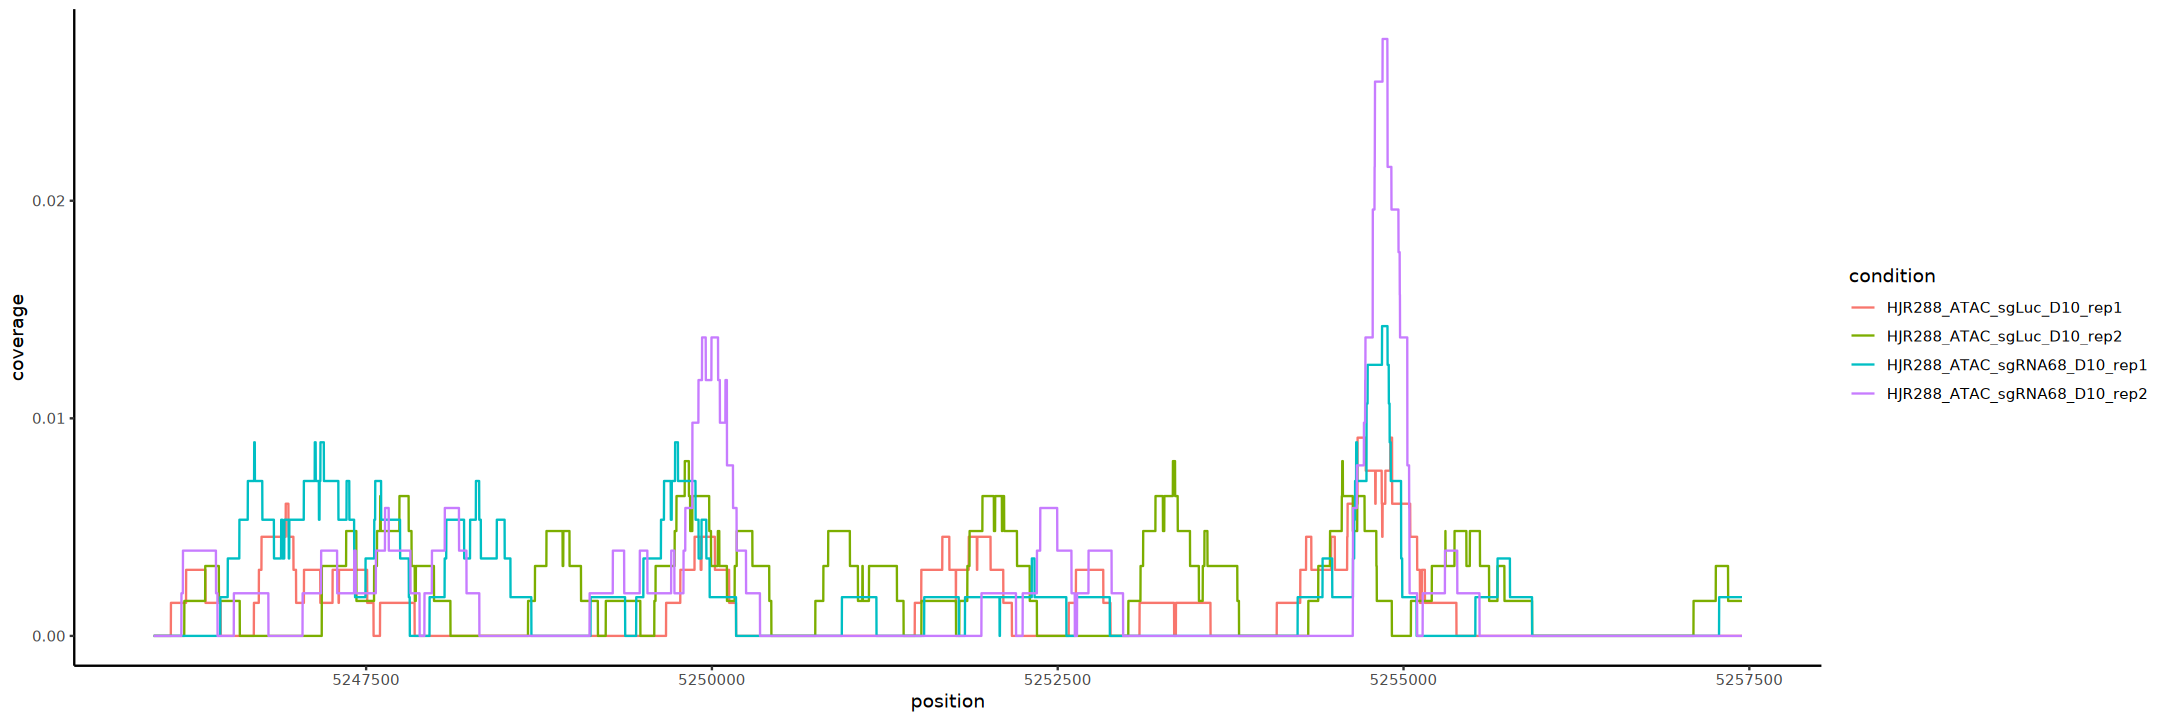

In [44]:
# Reformat into data.frame for visualization
plot_data <- lapply(
    samples,
    function(sample){
        data.frame(
            position = start(resize(locusBins, 1, fix = "center")),
            coverage = tracks[, sample],
            condition = sample
        )
    }
)
plot_data <- data.table::rbindlist(plot_data)

options(repr.plot.width = 18, repr.plot.height = 6)
p <- ggplot(plot_data) +
  geom_line(aes(x=position, y=coverage, color=condition)) +
  theme_classic()
pdf(paste0("/home/yanhu/data/DddA/HJR288/plots/single_sgRNA_validation/accessibility_tracks.pdf"), 
   width=12, height=4)
print(p)
dev.off()
print(p)

In [45]:
bw_dir <- "/home/yanhu/data/DddA/HJR288/single_sgRNA_validation/bigwig/"
system(paste0("mkdir -p ", bw_dir))
library(TxDb.Hsapiens.UCSC.hg38.knownGene)
txdb <- TxDb.Hsapiens.UCSC.hg38.knownGene

# Export the track of each sample to bigwig
for(sample in colnames(tracks)){
    bw <- locusBins
    bw$score <- tracks[, sample]
    seqinfo(bw) <- seqinfo(txdb)[seqnames(seqinfo(bw))]
    rtracklayer::export.bw(bw, paste0(bw_dir, sample, ".bigwig"), format = 'bigWig')
}

# Calculate the average across replicates
conditions <- stringr::str_split_fixed(colnames(tracks), "_rep", 3)[, 1]
for(condition in unique(conditions)){
    bw <- locusBins
    bw$score <- rowMeans(tracks[, conditions == condition])
    seqinfo(bw) <- seqinfo(txdb)[seqnames(seqinfo(bw))]
    rtracklayer::export.bw(bw, paste0(bw_dir, condition, ".bigwig"), format = 'bigWig')
}